In [7]:
import librosa


In [ ]:
pcm_to_numpy()


MP3 파일을 WAV로 변환 완료: news_data.wav
WAV 파일에서 PCM 추출 완료: news_data.pcm
PCM 파일을 numpy 배열로 변환 완료, 데이터 크기: (2680832,)
노이즈 제거 중...
MFCC 특성 추출 중...


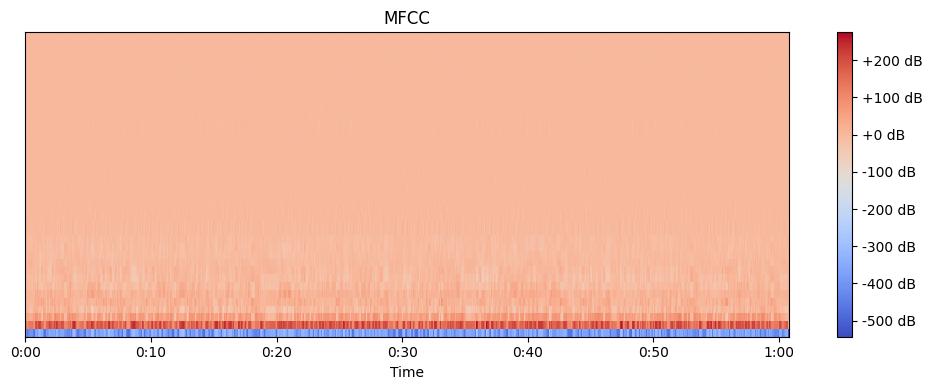

In [9]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
from pydub import AudioSegment
import os
from scipy import signal

# MP3를 WAV로 변환
def mp3_to_wav(mp3_path, wav_path):
    audio = AudioSegment.from_mp3(mp3_path)
    audio.export(wav_path, format='wav')
    print(f"MP3 파일을 WAV로 변환 완료: {wav_path}")

# WAV에서 PCM 추출 (PCM은 WAV의 오디오 데이터 부분)
def wav_to_pcm(wav_path, pcm_path):
    # WAV 파일에서 샘플레이트와 데이터 읽기
    sample_rate, data = wavfile.read(wav_path)
    
    # PCM 파일로 저장 (헤더 없이 raw 데이터만 저장)
    data.tofile(pcm_path)
    print(f"WAV 파일에서 PCM 추출 완료: {pcm_path}")
    
    return sample_rate, data.dtype

# PCM 파일에서 numpy 배열로 변환
def pcm_to_numpy(pcm_path, sample_rate, dtype=np.int16):
    # PCM 파일에서 raw 데이터 읽기
    with open(pcm_path, 'rb') as f:
        pcm_data = np.fromfile(f, dtype=dtype)
    
    print(f"PCM 파일을 numpy 배열로 변환 완료, 데이터 크기: {pcm_data.shape}")
    return pcm_data

# 노이즈 제거 (Scipy의 필터 사용)
def remove_noise(audio_data, sample_rate):
    # 노이즈 감소를 위한 저역 통과 필터 설계
    b, a = signal.butter(5, 3000/(sample_rate/2), 'low')
    filtered_data = signal.filtfilt(b, a, audio_data)
    
    return filtered_data

# MFCC 특성 추출
def extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    # Librosa는 float32 타입과 -1~1 범위를 선호하므로 데이터 타입 변환
    if audio_data.dtype != np.float32:
        if np.issubdtype(audio_data.dtype, np.integer):
            # 정수형 데이터인 경우 iinfo 사용
            audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
        else:
            # 이미 부동소수점 데이터인 경우 finfo 사용하거나 그냥 변환
            audio_data = audio_data.astype(np.float32)
            # 만약 데이터 범위가 이미 [-1, 1]이 아니라면 정규화 필요할 수 있음
            if np.abs(audio_data).max() > 1.0:
                audio_data = audio_data / np.abs(audio_data).max()
        
    # MFCC 추출
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    
    # 델타 특성 추가 (MFCC의 1차, 2차 미분)
    delta_mfcc = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)
    
    # 모든 특성 결합
    mfcc_combined = np.concatenate([mfcc_features, delta_mfcc, delta2_mfcc])
    
    return mfcc_combined

# MFCC 시각화
def visualize_mfcc(mfcc_features, sample_rate):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc_features, x_axis='time', sr=sample_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# 메인 프로세스
def process_audio_file(mp3_file_path):
    # 파일 이름 및 경로 설정
    filename = os.path.splitext(os.path.basename(mp3_file_path))[0]
    wav_file_path = f"{filename}.wav"
    pcm_file_path = f"{filename}.pcm"
    
    # MP3 -> WAV 변환
    mp3_to_wav(mp3_file_path, wav_file_path)
    
    # WAV -> PCM 추출
    sample_rate, dtype = wav_to_pcm(wav_file_path, pcm_file_path)
    
    # PCM -> Numpy 변환
    audio_data = pcm_to_numpy(pcm_file_path, sample_rate, dtype)
    
    # 노이즈 제거
    print("노이즈 제거 중...")
    filtered_data = remove_noise(audio_data, sample_rate)
    
    # MFCC 추출
    print("MFCC 특성 추출 중...")
    mfcc_features = extract_mfcc(filtered_data, sample_rate)
    
    # MFCC 시각화
    visualize_mfcc(mfcc_features, sample_rate)
    
    return {
        'audio_data': audio_data,
        'filtered_data': filtered_data,
        'mfcc_features': mfcc_features,
        'sample_rate': sample_rate
    }

# 사용 예시
mp3_file_path = "news_data.mp3"  # MP3 파일 경로
results = process_audio_file(mp3_file_path)

MP3 파일 로드 중: news_data.mp3


/tmp/ipykernel_1596/2763420669.py:173: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(mp3_path, sr=None)
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


오디오 데이터 로드 완료, 샘플 레이트: 44100, 데이터 크기: (1340416,)


/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 54805 (\N{HANGUL SYLLABLE HYEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:138: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:1

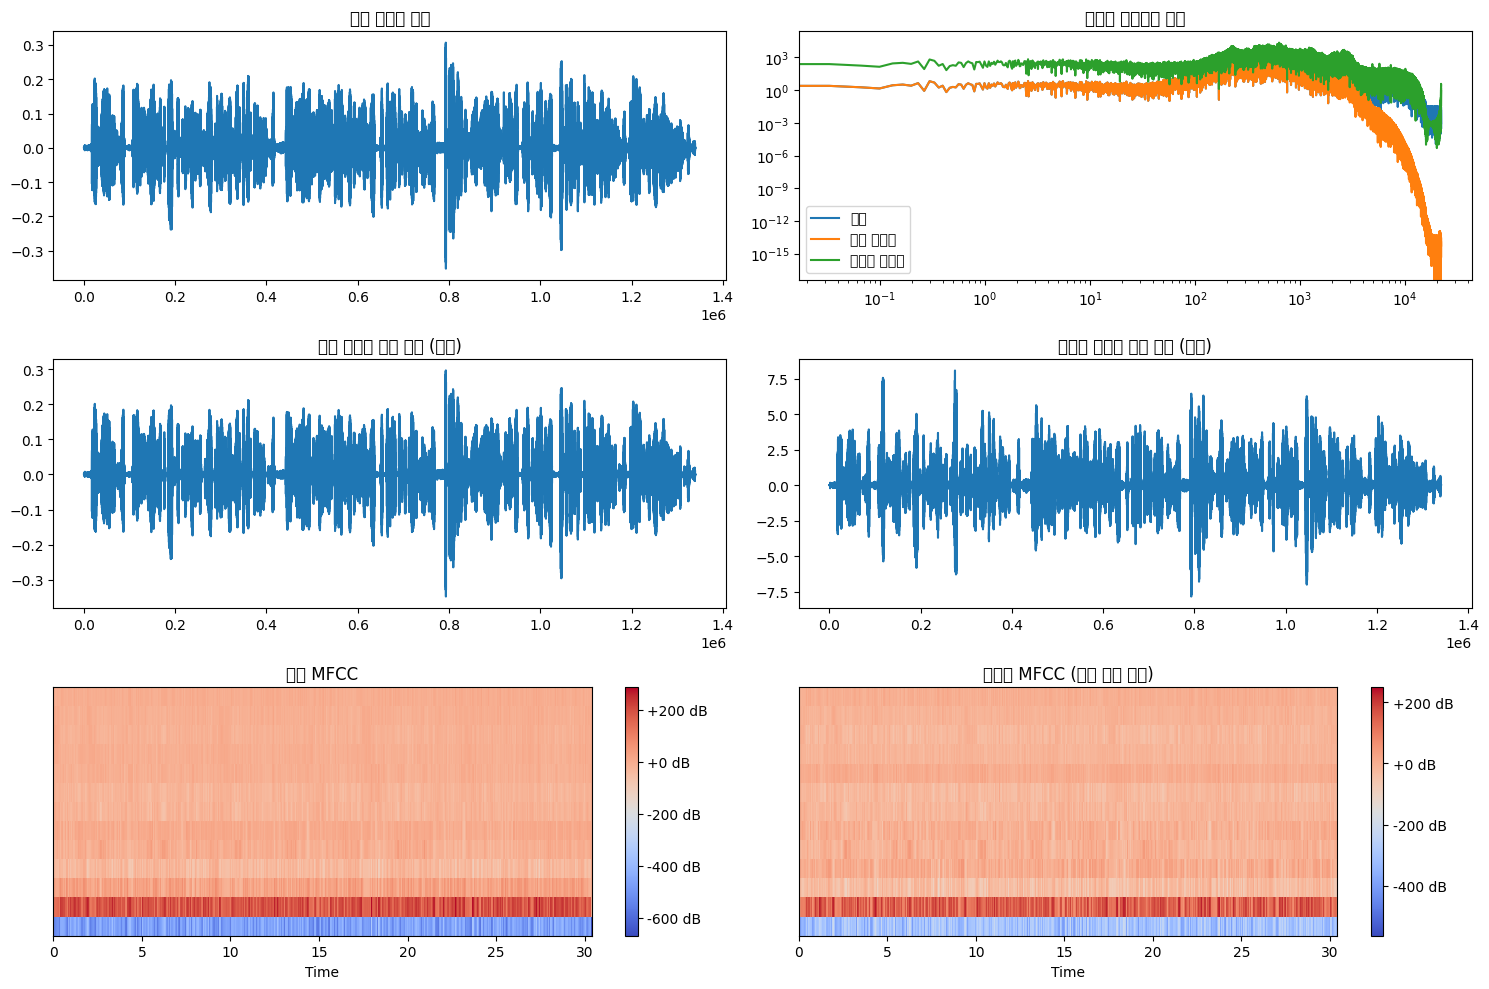

원본 MFCC 특성 차원: (13, 2619)
개선된 MFCC 특성 차원: (39, 2619)


/tmp/ipykernel_1596/2763420669.py:159: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:159: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:159: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:159: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1596/2763420669.py:159: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) mi

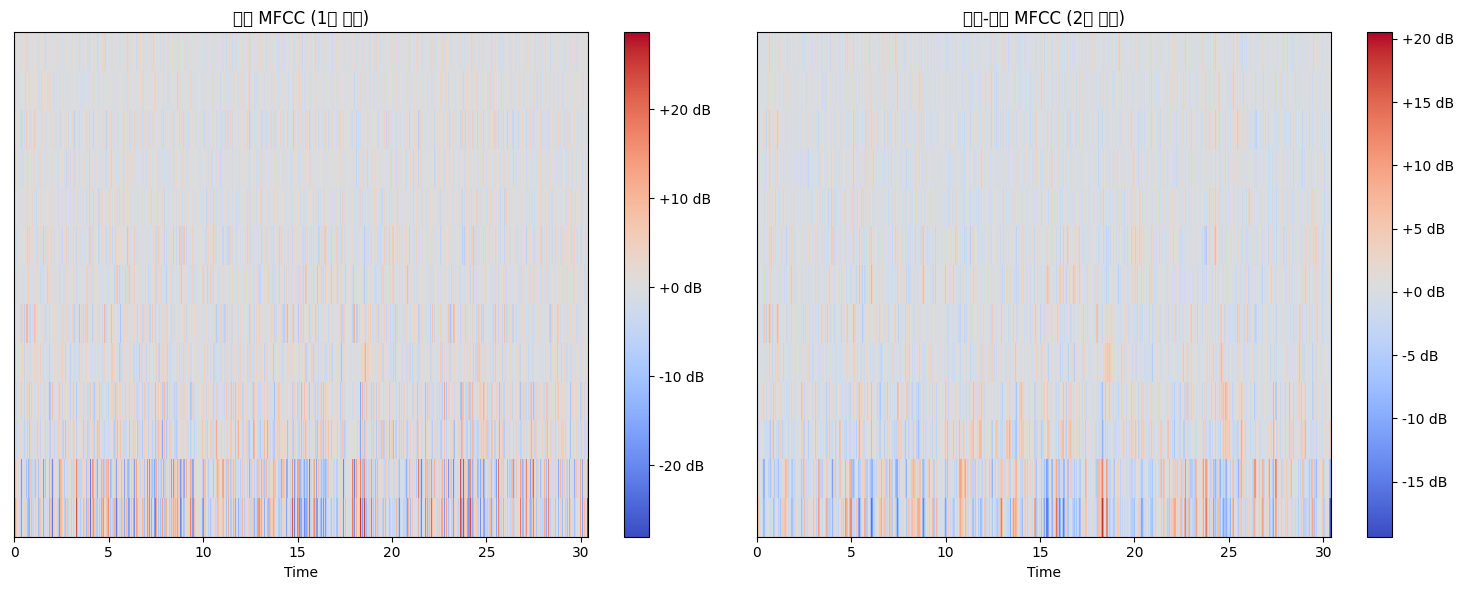


=== 코드 개선 사항 요약 ===
1. 데이터 타입 처리 강화:
   - 정수형/부동소수점에 따른 올바른 정규화 적용
   - float32 데이터에 대한 적절한 예외 처리

2. MFCC 특성 확장:
   - 기본 MFCC: 13개 특성
   - 델타 특성 추가: +13개 특성
   - 델타-델타 특성 추가: +13개 특성


NameError: name 'mfcc_original' is not defined

Loading MP3 file: news_data.mp3
Audio data loaded, sample rate: 44100, data size: (1340416,)


/tmp/ipykernel_1596/2813084001.py:135: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(mp3_path, sr=None)
/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


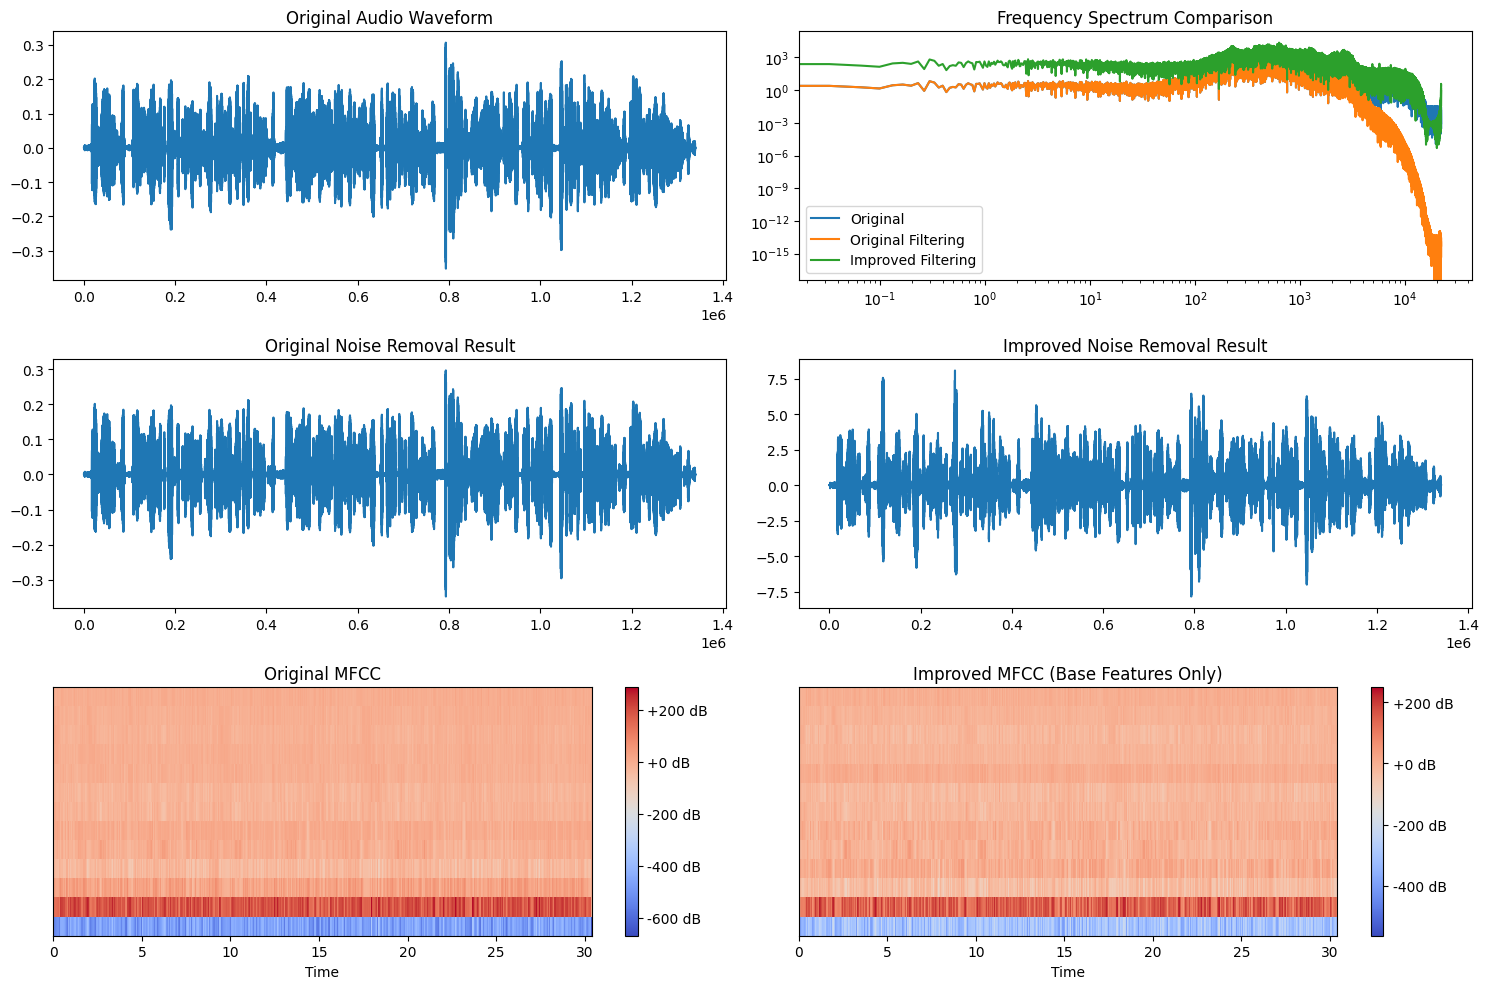

Original MFCC Features Dimension: (13, 2619)
Improved MFCC Features Dimension: (39, 2619)


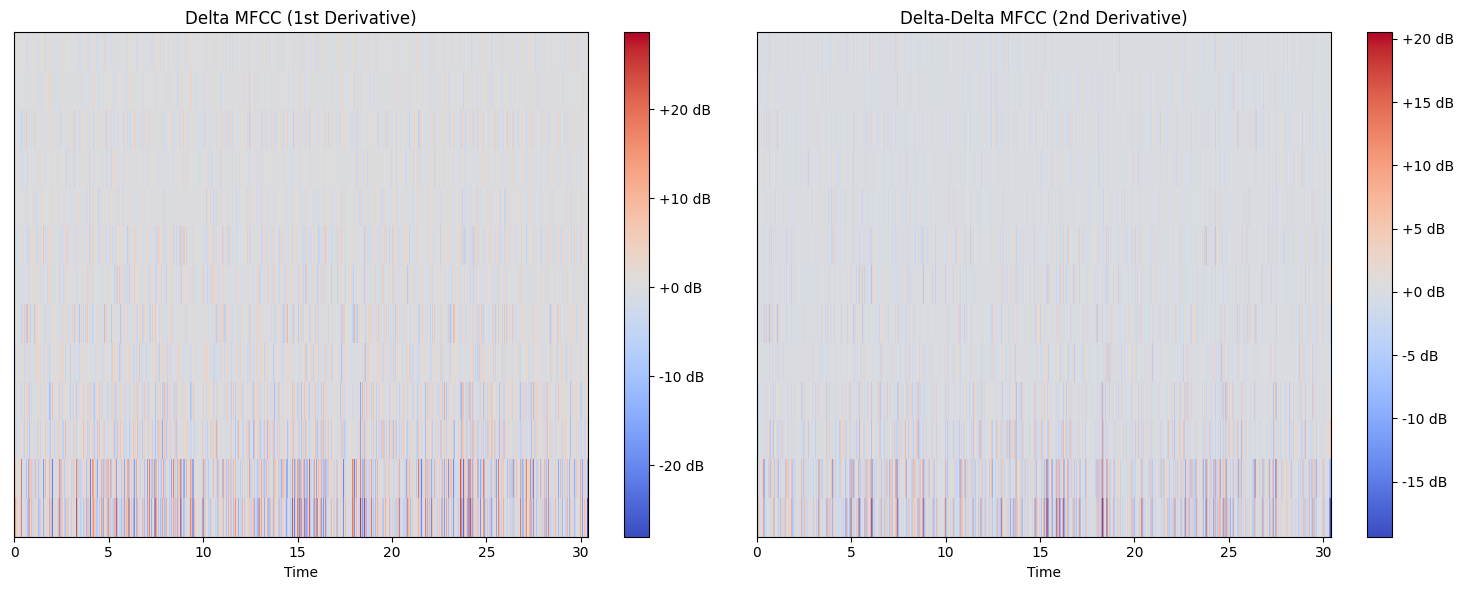


=== Code Improvement Summary ===
1. Data Type Handling:
   - Proper normalization based on integer/float type
   - Appropriate exception handling for float32 data

2. MFCC Feature Expansion:
   - Base MFCC: 13 features
   - Delta features: +13 features
   - Delta-Delta features: +13 features
   - Total feature increase: 13 → 39

3. Noise Removal Enhancement:
   - Original: Low-pass filter only
   - Improved: Low-pass filter + Spectral subtraction


In [12]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
from pydub import AudioSegment
import os
from scipy import signal

def original_extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    if audio_data.dtype != np.float32:
        try:
            audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
        except ValueError:
            audio_data = audio_data.astype(np.float32)
            
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc_features

def original_remove_noise(audio_data, sample_rate):
    b, a = signal.butter(5, 3000/(sample_rate/2), 'low')
    filtered_data = signal.filtfilt(b, a, audio_data)
    return filtered_data

def improved_extract_mfcc(audio_data, sample_rate, n_mfcc=13):
    if audio_data.dtype != np.float32:
        if np.issubdtype(audio_data.dtype, np.integer):
            audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
        else:
            audio_data = audio_data.astype(np.float32)
            if np.abs(audio_data).max() > 1.0:
                audio_data = audio_data / np.abs(audio_data).max()
    
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    
    delta_mfcc = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)
    
    mfcc_combined = np.concatenate([mfcc_features, delta_mfcc, delta2_mfcc])
    
    return mfcc_combined

def improved_remove_noise(audio_data, sample_rate):
    b, a = signal.butter(5, 3000/(sample_rate/2), 'low')
    filtered_data = signal.filtfilt(b, a, audio_data)
    
    S = librosa.stft(filtered_data)
    S_db = librosa.amplitude_to_db(np.abs(S))
    
    noise_floor = np.mean(S_db[:, :10], axis=1, keepdims=True)
    S_db_denoised = S_db - noise_floor - 1.0
    S_db_denoised = np.maximum(S_db_denoised, S_db - 10)
    
    S_denoised = librosa.db_to_amplitude(S_db_denoised) * np.exp(1j * np.angle(S))
    filtered_data_enhanced = librosa.istft(S_denoised, length=len(filtered_data))
    
    return filtered_data_enhanced

def compare_audio_processing(audio_data, sample_rate):
    filtered_original = original_remove_noise(audio_data, sample_rate)
    filtered_improved = improved_remove_noise(audio_data, sample_rate)
    
    mfcc_original = original_extract_mfcc(filtered_original, sample_rate)
    mfcc_improved = improved_extract_mfcc(filtered_improved, sample_rate)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 2, 1)
    plt.title('Original Audio Waveform')
    plt.plot(audio_data)
    
    plt.subplot(3, 2, 3)
    plt.title('Original Noise Removal Result')
    plt.plot(filtered_original)
    
    plt.subplot(3, 2, 4)
    plt.title('Improved Noise Removal Result')
    plt.plot(filtered_improved)
    
    plt.subplot(3, 2, 5)
    plt.title('Original MFCC')
    librosa.display.specshow(mfcc_original, x_axis='time', sr=sample_rate)
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(3, 2, 6)
    plt.title('Improved MFCC (Base Features Only)')
    librosa.display.specshow(mfcc_improved[:13], x_axis='time', sr=sample_rate)
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(3, 2, 2)
    plt.title('Frequency Spectrum Comparison')
    
    original_spectrum = np.abs(np.fft.rfft(audio_data))
    original_filtered_spectrum = np.abs(np.fft.rfft(filtered_original))
    improved_filtered_spectrum = np.abs(np.fft.rfft(filtered_improved))
    
    freqs = np.fft.rfftfreq(len(audio_data), 1/sample_rate)
    
    plt.loglog(freqs, original_spectrum, label='Original')
    plt.loglog(freqs, original_filtered_spectrum, label='Original Filtering')
    plt.loglog(freqs, improved_filtered_spectrum, label='Improved Filtering')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Original MFCC Features Dimension: {mfcc_original.shape}")
    print(f"Improved MFCC Features Dimension: {mfcc_improved.shape}")
    
    if mfcc_improved.shape[0] > 13:
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.title('Delta MFCC (1st Derivative)')
        librosa.display.specshow(mfcc_improved[13:26], x_axis='time', sr=sample_rate)
        plt.colorbar(format='%+2.0f dB')
        
        plt.subplot(1, 2, 2)
        plt.title('Delta-Delta MFCC (2nd Derivative)')
        librosa.display.specshow(mfcc_improved[26:], x_axis='time', sr=sample_rate)
        plt.colorbar(format='%+2.0f dB')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'filtered_original': filtered_original,
        'filtered_improved': filtered_improved,
        'mfcc_original': mfcc_original,
        'mfcc_improved': mfcc_improved
    }

def compare_processing_from_mp3(mp3_path):
    print(f"Loading MP3 file: {mp3_path}")
    y, sr = librosa.load(mp3_path, sr=None)
    
    print(f"Audio data loaded, sample rate: {sr}, data size: {y.shape}")
    
    results = compare_audio_processing(y, sr)
    
    # 결과에서 MFCC 특성 크기 정보 가져오기
    mfcc_original = results['mfcc_original']
    mfcc_improved = results['mfcc_improved']
    
    print("\n=== Code Improvement Summary ===")
    print("1. Data Type Handling:")
    print("   - Proper normalization based on integer/float type")
    print("   - Appropriate exception handling for float32 data")
    
    print("\n2. MFCC Feature Expansion:")
    print("   - Base MFCC: 13 features")
    print("   - Delta features: +13 features")
    print("   - Delta-Delta features: +13 features")
    print(f"   - Total feature increase: {mfcc_original.shape[0]} → {mfcc_improved.shape[0]}")
    
    print("\n3. Noise Removal Enhancement:")
    print("   - Original: Low-pass filter only")
    print("   - Improved: Low-pass filter + Spectral subtraction")
    
    return results

mp3_file_path = "news_data.mp3"
results = compare_processing_from_mp3(mp3_file_path)

Loading audio file: news_data.wav
Audio duration: 30.39 seconds
Sample rate: 44100 Hz


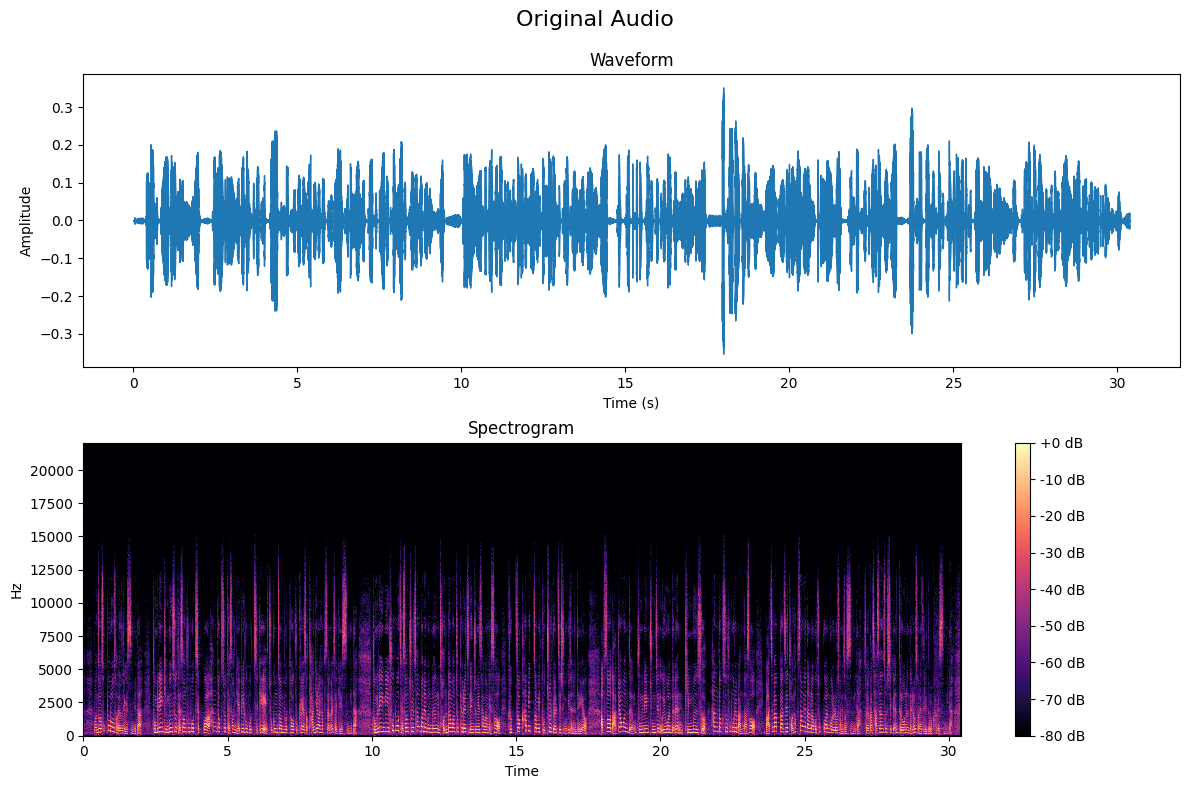

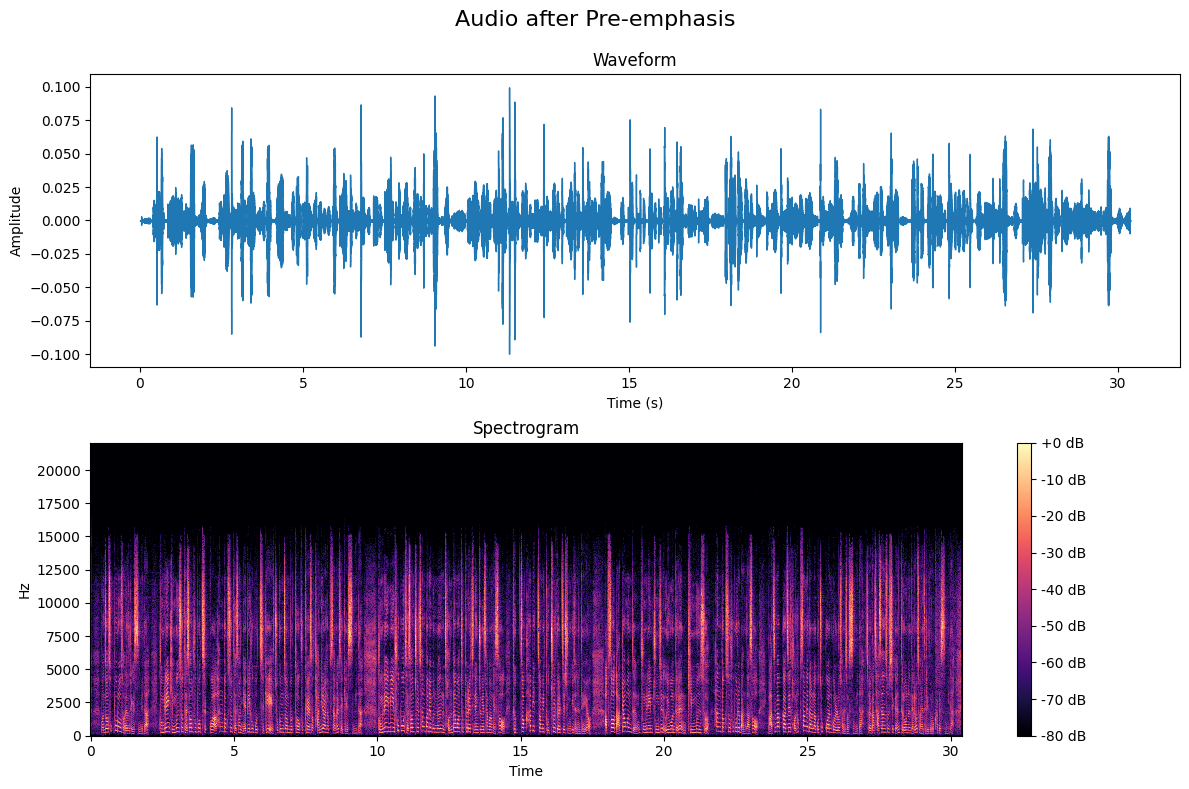

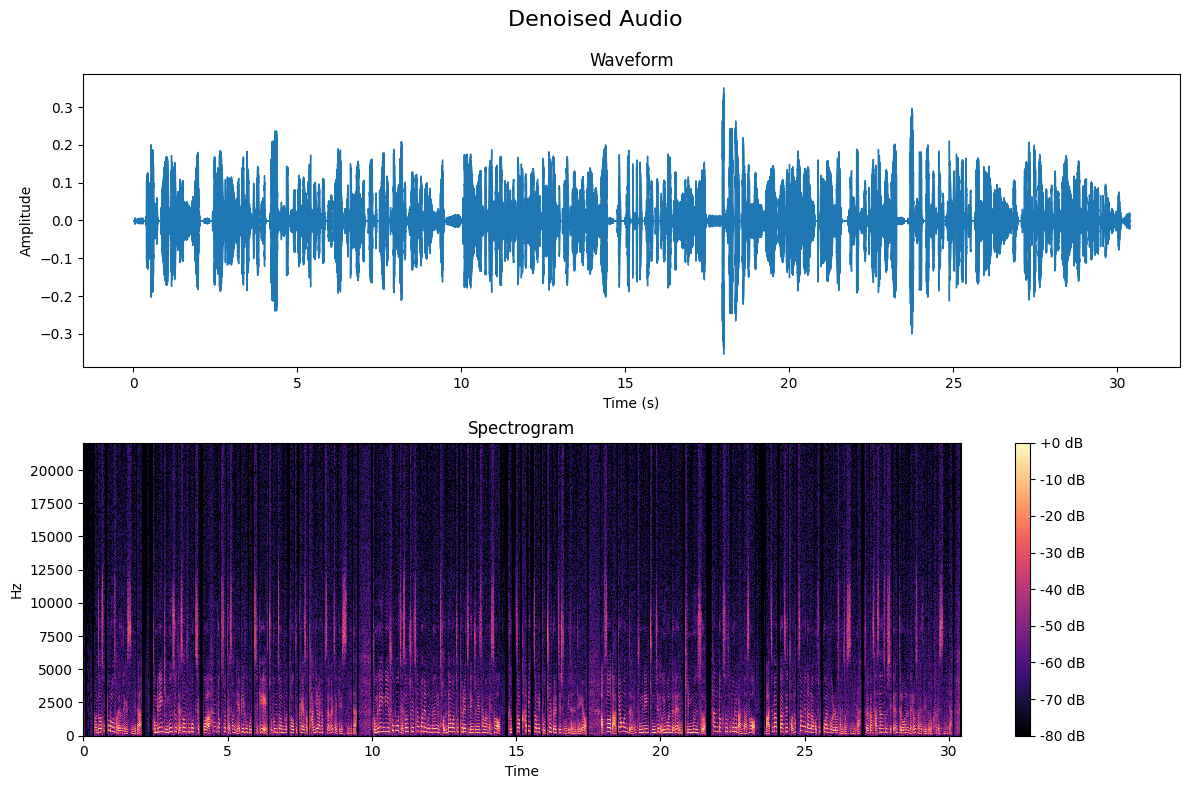

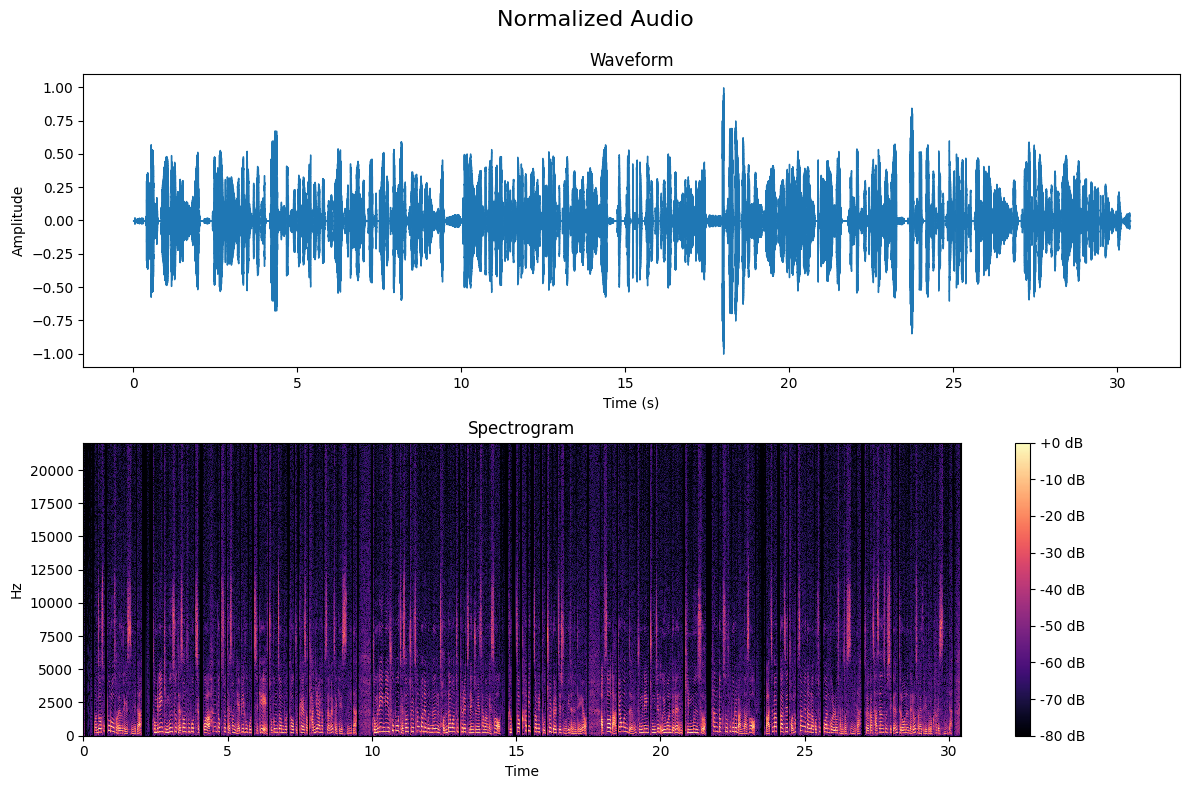

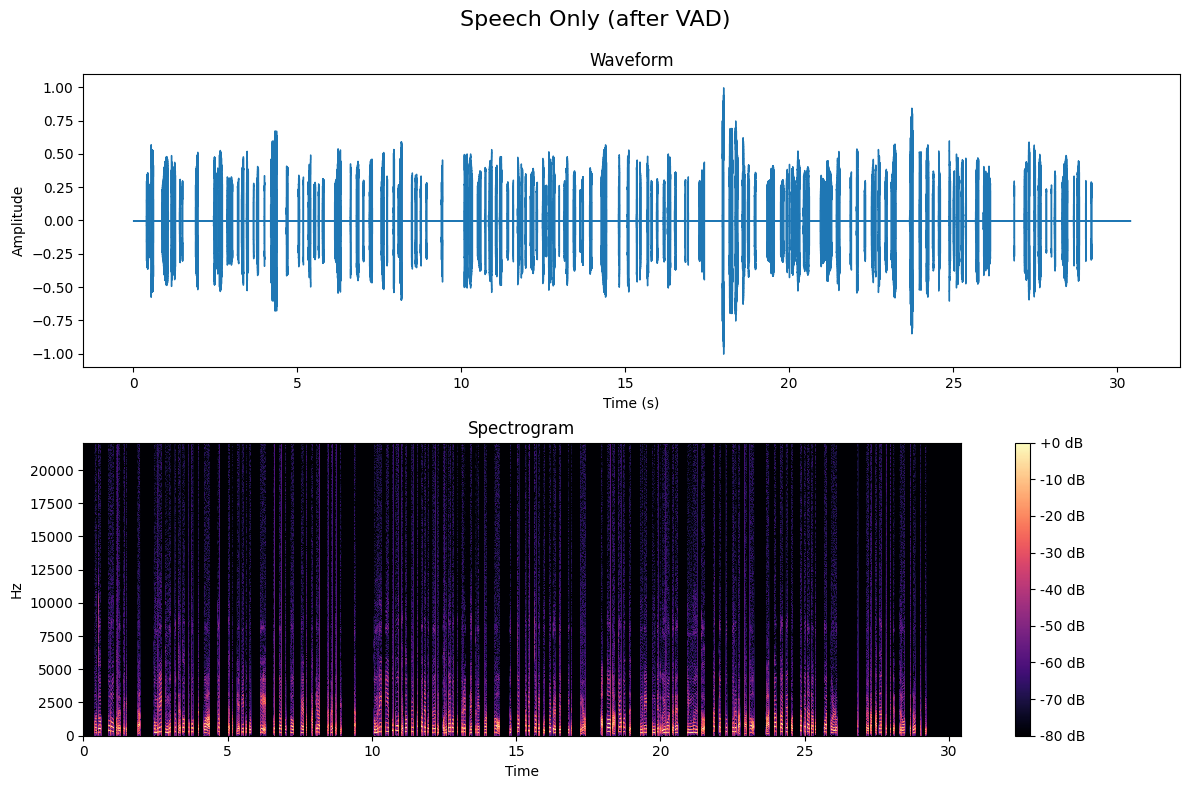

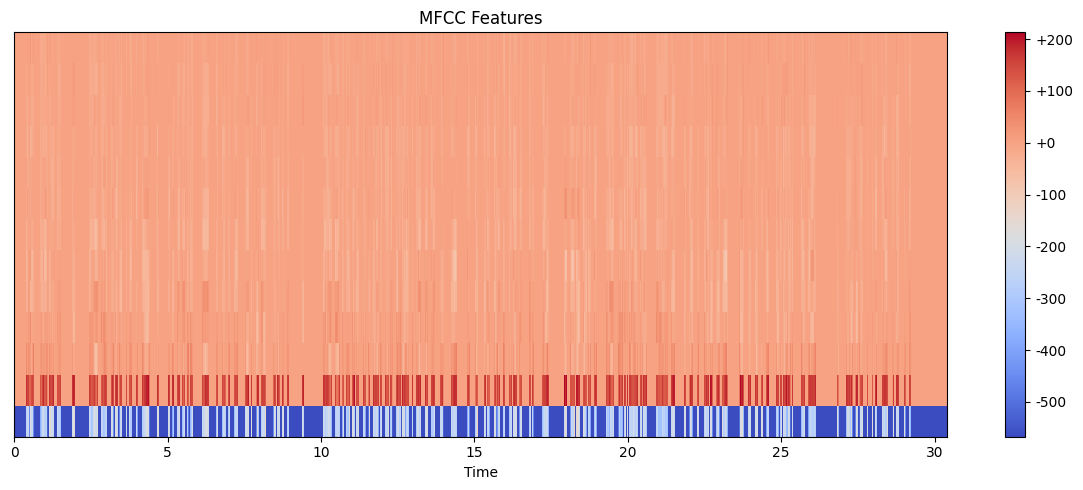

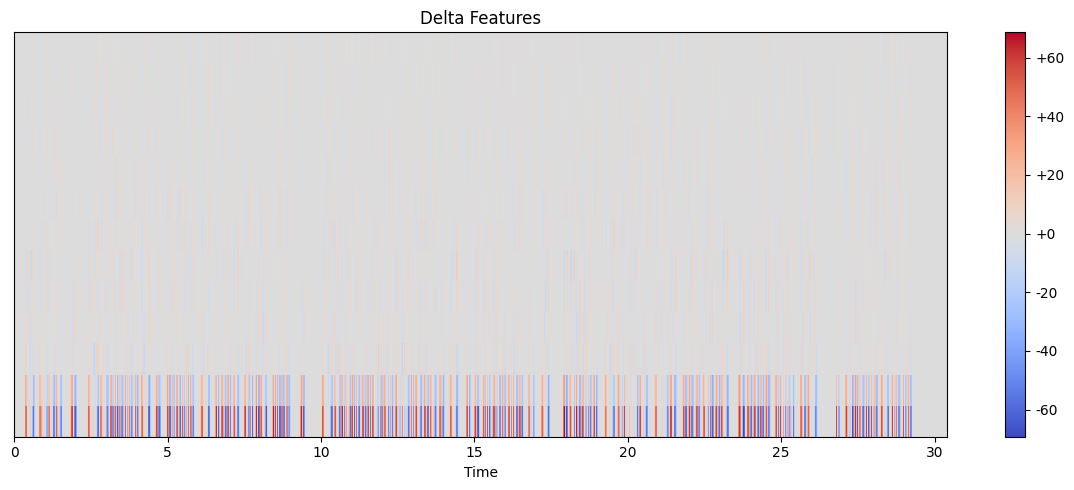

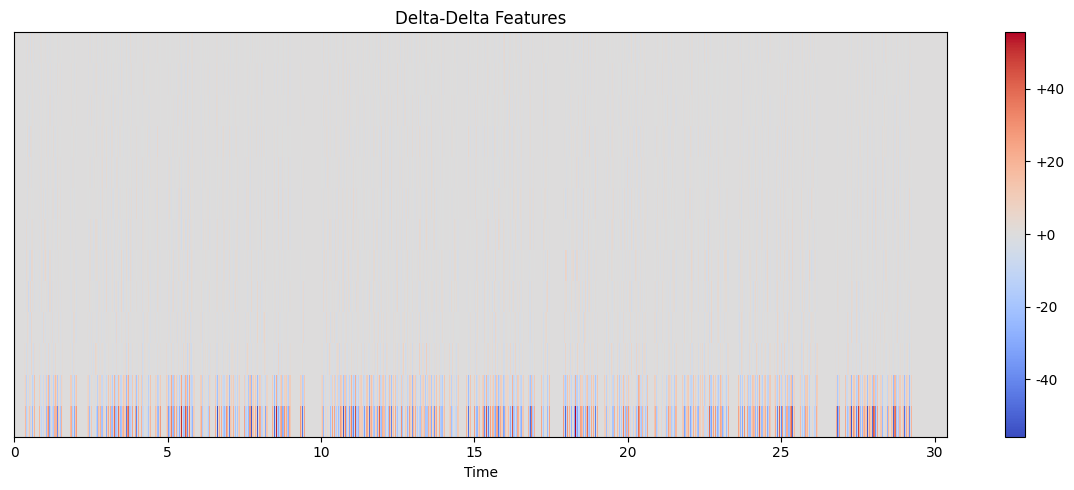

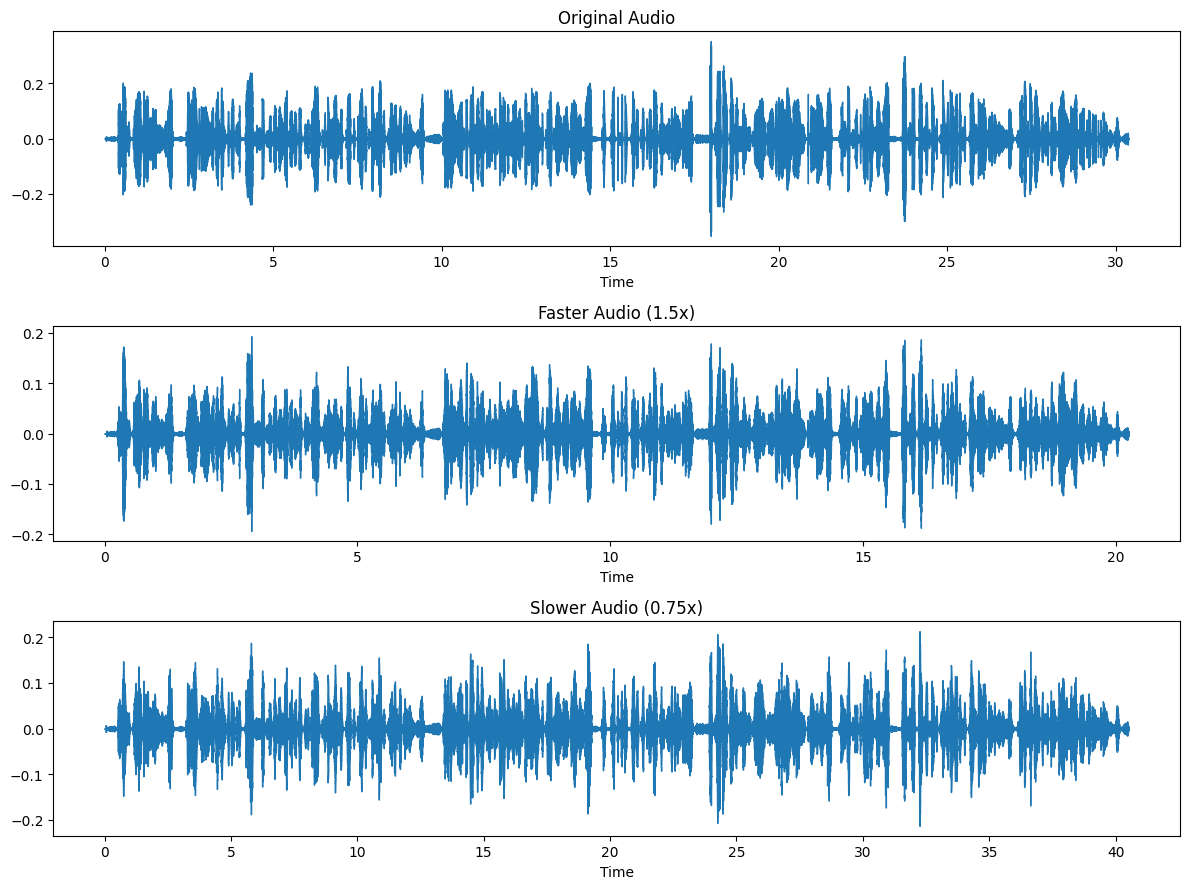

In [15]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
import scipy.fftpack as fft

# 1. 프리엠퍼시스 (Pre-emphasis)
def apply_preemphasis(audio_data, coef=0.97):
    """Apply pre-emphasis filter to audio data"""
    return np.append(audio_data[0], audio_data[1:] - coef * audio_data[:-1])

# 2. 프레임 분할 및 윈도잉 (Framing & Windowing)
def frame_signal(audio_data, sample_rate, frame_size=0.025, frame_stride=0.01, window='hamming'):
    """Divide the audio signal into overlapping frames and apply window function"""
    frame_length = int(frame_size * sample_rate)
    frame_step = int(frame_stride * sample_rate)
    
    signal_length = len(audio_data)
    num_frames = 1 + int(np.ceil((signal_length - frame_length) / frame_step))
    
    pad_length = (num_frames - 1) * frame_step + frame_length
    padded_signal = np.append(audio_data, np.zeros(pad_length - signal_length))
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = padded_signal[indices.astype(np.int32)]
    
    if window == 'hamming':
        frames = frames * np.hamming(frame_length)
    elif window == 'hanning':
        frames = frames * np.hanning(frame_length)
    
    return frames

# 3. 스펙트럼 분석 (Spectral Analysis)
def compute_power_spectrum(frames, nfft=512):
    """Compute the power spectrum of each frame using FFT"""
    mag_frames = np.absolute(np.fft.rfft(frames, nfft))
    pow_frames = (1.0 / nfft) * (mag_frames ** 2)
    return pow_frames

# 4. 멜 필터뱅크 (Mel Filter Bank) - librosa 활용
def get_mel_filterbanks(nfilt=40, nfft=512, sample_rate=16000, low_freq=0, high_freq=None):
    """Create a Mel filter bank using librosa"""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # librosa의 mel filterbank 생성 함수 사용
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=nfft, n_mels=nfilt, 
                                  fmin=low_freq, fmax=high_freq)
    return mel_basis

# 5. MFCC (Mel-Frequency Cepstral Coefficients) - librosa 활용
def compute_mfcc(audio_data, sample_rate, num_cepstral=13):
    """Compute MFCC features from an audio signal using librosa"""
    # librosa의 MFCC 추출 함수 사용
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=num_cepstral)
    return mfcc_features

# 6. 델타 및 델타-델타 특성 (Delta and Delta-Delta Features) - librosa 활용
def compute_deltas(features):
    """Compute delta features using librosa"""
    delta_features = librosa.feature.delta(features)
    delta2_features = librosa.feature.delta(features, order=2)
    return delta_features, delta2_features

# 7. 노이즈 제거 (Noise Reduction) - 간단한 방법
def simple_noise_reduction(audio_data, sample_rate, noise_threshold=0.005):
    """Apply simple noise reduction by thresholding"""
    # 간단한 임계값 기반 노이즈 제거
    denoised = np.copy(audio_data)
    denoised[np.abs(denoised) < noise_threshold] = 0
    return denoised

# 8. 정규화 기법 (Normalization Techniques)
def normalize_audio(audio_data, method='peak'):
    """Normalize audio data"""
    if method == 'peak':
        # 피크 기반 정규화 (-1 ~ 1 범위)
        return audio_data / np.max(np.abs(audio_data))
    elif method == 'rms':
        # RMS 기반 정규화
        rms = np.sqrt(np.mean(audio_data**2))
        return audio_data / (rms * 10)  # -0.1 ~ 0.1 범위
    else:
        return audio_data

# 9. VAD (Voice Activity Detection) - 에너지 기반 간단 구현
def simple_vad(audio_data, sample_rate, frame_size=0.025, frame_stride=0.01, energy_threshold=0.1):
    """Simple energy-based Voice Activity Detection"""
    # 프레임 길이와 간격을 샘플 단위로 변환
    frame_length = int(frame_size * sample_rate)
    frame_step = int(frame_stride * sample_rate)
    
    # 프레임 분할
    frames = frame_signal(audio_data, sample_rate, frame_size, frame_stride)
    
    # 각 프레임의 에너지 계산
    energy = np.sum(frames**2, axis=1)
    
    # 에너지 정규화
    energy = energy / np.max(energy)
    
    # 임계값 적용
    speech_frames = energy > energy_threshold
    
    # 프레임 단위 결정을 샘플 단위로 변환
    # 정확한 길이의 마스크 생성
    speech_mask = np.zeros_like(audio_data)
    
    for i, is_speech in enumerate(speech_frames):
        start = i * frame_step
        end = min(start + frame_length, len(audio_data))
        speech_mask[start:end] = 1 if is_speech else 0
    
    # 정확히 원본 오디오 길이와 일치하도록 함
    speech_mask = speech_mask[:len(audio_data)]
    
    return speech_mask, speech_frames

# 10. 시간 스케일링 (Time Scaling) - librosa 활용
def simple_time_scale(audio_data, scale_factor=1.0):
    """Scale the speed of an audio signal without changing pitch using librosa"""
    try:
        return librosa.effects.time_stretch(audio_data, rate=scale_factor)
    except TypeError:
        # 이전 librosa 버전 호환성
        try:
            return librosa.effects.time_stretch(y=audio_data, rate=scale_factor)
        except:
            print("librosa.effects.time_stretch 함수에 문제가 있습니다. 오디오 원본을 반환합니다.")
            return audio_data

# 시각화 함수
def plot_audio_features(audio_data, sample_rate, title="Audio Features"):
    """Plot audio waveform and spectrogram"""
    plt.figure(figsize=(12, 8))
    
    # 파형 그리기
    plt.subplot(2, 1, 1)
    plt.title("Waveform")
    librosa.display.waveshow(audio_data, sr=sample_rate)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # 스펙트로그램 그리기
    plt.subplot(2, 1, 2)
    plt.title("Spectrogram")
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    librosa.display.specshow(D, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# MFCC 시각화 함수
def plot_mfcc(mfcc_features, sample_rate, title="MFCC Features"):
    """Plot MFCC features"""
    plt.figure(figsize=(12, 5))
    plt.title(title)
    librosa.display.specshow(mfcc_features, x_axis='time', sr=sample_rate)
    plt.colorbar(format='%+2.0f')
    plt.tight_layout()
    plt.show()

# 오디오 처리 함수
def process_audio(audio_file=None, audio_data=None, sample_rate=None):
    """Process audio with various techniques and visualize results"""
    # 1. 오디오 로드
    if audio_file is not None:
        print(f"Loading audio file: {audio_file}")
        audio_data, sample_rate = librosa.load(audio_file, sr=None)
    
    if audio_data is None or sample_rate is None:
        raise ValueError("Must provide either audio_file or both audio_data and sample_rate")
    
    print(f"Audio duration: {len(audio_data)/sample_rate:.2f} seconds")
    print(f"Sample rate: {sample_rate} Hz")
    
    # 2. 오디오 시각화
    plot_audio_features(audio_data, sample_rate, "Original Audio")
    
    # 3. 프리엠퍼시스 적용
    emphasized = apply_preemphasis(audio_data)
    plot_audio_features(emphasized, sample_rate, "Audio after Pre-emphasis")
    
    # 4. 노이즈 제거
    denoised = simple_noise_reduction(audio_data, sample_rate)
    plot_audio_features(denoised, sample_rate, "Denoised Audio")
    
    # 5. 정규화
    normalized = normalize_audio(denoised, 'peak')
    plot_audio_features(normalized, sample_rate, "Normalized Audio")
    
    # 6. VAD 적용
    vad_mask, vad_frames = simple_vad(normalized, sample_rate)
    speech_only = normalized * vad_mask
    plot_audio_features(speech_only, sample_rate, "Speech Only (after VAD)")
    
    # 7. MFCC 추출
    mfcc_features = compute_mfcc(speech_only, sample_rate)
    plot_mfcc(mfcc_features, sample_rate, "MFCC Features")
    
    # 8. 델타 및 델타-델타 계산
    delta_features, delta2_features = compute_deltas(mfcc_features)
    
    # 델타 특성 시각화
    plot_mfcc(delta_features, sample_rate, "Delta Features")
    plot_mfcc(delta2_features, sample_rate, "Delta-Delta Features")
    
    # 9. 시간 스케일링 (속도 변경)
    try:
        # 시간 스케일링 적용
        faster_audio = simple_time_scale(audio_data, 1.5)
        slower_audio = simple_time_scale(audio_data, 0.75)
        
        # 속도 변경 결과 시각화
        plt.figure(figsize=(12, 9))
        
        plt.subplot(3, 1, 1)
        plt.title("Original Audio")
        librosa.display.waveshow(audio_data, sr=sample_rate)
        
        plt.subplot(3, 1, 2)
        plt.title("Faster Audio (1.5x)")
        librosa.display.waveshow(faster_audio, sr=sample_rate)
        
        plt.subplot(3, 1, 3)
        plt.title("Slower Audio (0.75x)")
        librosa.display.waveshow(slower_audio, sr=sample_rate)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"시간 스케일링 적용 중 오류 발생: {e}")
    
    # 10. 결과 반환
    return {
        'audio_data': audio_data,
        'sample_rate': sample_rate,
        'emphasized': emphasized,
        'denoised': denoised,
        'normalized': normalized,
        'speech_only': speech_only,
        'mfcc_features': mfcc_features,
        'delta_features': delta_features,
        'delta2_features': delta2_features
    }

# 사용 예시
results = process_audio(audio_file="news_data.wav")

In [18]:
def preprocess_and_save_pcm(pcm_file=None, pcm_data=None, sample_rate=16000, bit_depth=16, channels=1, save_dir="processed_data"):
    """
    PCM 오디오 데이터를 전처리하고 결과를 PCM 및 특성 파일로 저장합니다.
    
    Parameters:
    -----------
    pcm_file : str, optional
        처리할 PCM 파일 경로
    pcm_data : ndarray, optional
        이미 로드된 PCM 데이터 배열
    sample_rate : int, default=16000
        PCM 데이터의 샘플 레이트 (Hz)
    bit_depth : int, default=16
        PCM 데이터의 비트 깊이 (8, 16, 24, 32)
    channels : int, default=1
        PCM 데이터의 채널 수 (1=모노, 2=스테레오)
    save_dir : str, default="processed_data"
        전처리된 데이터를 저장할 디렉토리
        
    Returns:
    --------
    dict
        전처리된 오디오 데이터와 특성을 포함하는 사전
    """
    import os
    import numpy as np
    
    # 1. PCM 파일 로드
    if pcm_file is not None:
        print(f"PCM 파일 로드 중: {pcm_file}")
        # PCM 데이터 타입 결정
        if bit_depth == 8:
            dtype = np.uint8
        elif bit_depth == 16:
            dtype = np.int16
        elif bit_depth == 24 or bit_depth == 32:
            dtype = np.int32
        else:
            raise ValueError("지원되지 않는 비트 깊이입니다. 8, 16, 24, 32 중 하나여야 합니다.")
        
        # PCM 파일 읽기
        with open(pcm_file, 'rb') as f:
            pcm_data = np.frombuffer(f.read(), dtype=dtype)
        
        # 스테레오인 경우 채널 처리
        if channels == 2:
            pcm_data = pcm_data.reshape(-1, 2)
            # 모노로 변환 (평균)
            pcm_data = pcm_data.mean(axis=1)
    
    if pcm_data is None:
        raise ValueError("PCM 파일 또는 PCM 데이터를 제공해야 합니다")
    
    print(f"PCM 데이터 길이: {len(pcm_data)}")
    print(f"오디오 길이: {len(pcm_data)/sample_rate:.2f}초")
    print(f"샘플 레이트: {sample_rate} Hz")
    
    # PCM 데이터를 float32로 변환 (-1.0 ~ 1.0 범위)
    if pcm_data.dtype == np.uint8:
        audio_data = (pcm_data.astype(np.float32) - 128) / 128.0
    else:
        max_value = float(np.iinfo(pcm_data.dtype).max)
        audio_data = pcm_data.astype(np.float32) / max_value
    
    # 2. 프리엠퍼시스 적용
    emphasized = apply_preemphasis(audio_data)
    
    # 3. 노이즈 제거
    denoised = simple_noise_reduction(emphasized, sample_rate)
    
    # 4. 정규화
    normalized = normalize_audio(denoised, 'peak')
    
    # 5. VAD 적용
    vad_mask, vad_frames = simple_vad(normalized, sample_rate)
    speech_only = normalized * vad_mask
    
    # 6. MFCC 추출
    mfcc_features = compute_mfcc(speech_only, sample_rate)
    
    # 7. 델타 및 델타-델타 계산
    delta_features, delta2_features = compute_deltas(mfcc_features)
    
    # 8. 데이터 저장
    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    
    # 파일명 기본 부분 설정
    if pcm_file is not None:
        base_name = os.path.splitext(os.path.basename(pcm_file))[0]
    else:
        base_name = "pcm_data"
    
    # 전처리된 오디오를 PCM 형식으로 저장
    output_dtype = np.int16  # 일반적으로 16비트 PCM 사용
    if bit_depth == 8:
        output_dtype = np.uint8
        # 8비트 PCM은 일반적으로 unsigned (0-255)
        pcm_processed = ((speech_only + 1.0) * 127.5).astype(output_dtype)
    else:
        # 16/24/32비트 PCM은 일반적으로 signed
        max_value = float(np.iinfo(output_dtype).max)
        pcm_processed = (speech_only * max_value).astype(output_dtype)
    
    with open(os.path.join(save_dir, f"{base_name}_processed.pcm"), 'wb') as f:
        pcm_processed.tofile(f)
    
    # 샘플 레이트 정보 저장 (메타데이터)
    # PCM은 헤더가 없으므로 필요한 메타데이터를 별도 파일로 저장
    metadata = {
        'sample_rate': sample_rate,
        'bit_depth': bit_depth,
        'channels': 1  # 처리 후에는 항상 모노
    }
    np.save(os.path.join(save_dir, f"{base_name}_metadata.npy"), metadata)
    
    # MFCC 특성 저장 (NumPy 형식)
    np.save(os.path.join(save_dir, f"{base_name}_mfcc.npy"), mfcc_features)
    
    # 델타 및 델타-델타 특성 저장
    np.save(os.path.join(save_dir, f"{base_name}_delta.npy"), delta_features)
    np.save(os.path.join(save_dir, f"{base_name}_delta2.npy"), delta2_features)
    
    # 모든 특성을 결합하여 저장 (모델 학습용)
    combined_features = np.vstack([mfcc_features, delta_features, delta2_features])
    np.save(os.path.join(save_dir, f"{base_name}_combined_features.npy"), combined_features)
    
    # HDF5 형식으로 모든 데이터 저장 (선택적)
    try:
        import h5py
        with h5py.File(os.path.join(save_dir, f"{base_name}_all_data.h5"), 'w') as f:
            f.create_dataset('audio_data', data=audio_data)
            f.create_dataset('speech_only', data=speech_only)
            f.create_dataset('mfcc', data=mfcc_features)
            f.create_dataset('delta', data=delta_features)
            f.create_dataset('delta2', data=delta2_features)
            f.create_dataset('combined', data=combined_features)
            f.attrs['sample_rate'] = sample_rate
            f.attrs['bit_depth'] = bit_depth
            f.attrs['channels'] = 1
    except ImportError:
        print("h5py 라이브러리가 설치되지 않아 HDF5 형식으로 저장하지 않습니다.")
    
    print(f"전처리된 데이터가 {save_dir} 디렉토리에 저장되었습니다.")
    print(f"PCM 파일: {os.path.join(save_dir, f'{base_name}_processed.pcm')}")
    print(f"메타데이터: {os.path.join(save_dir, f'{base_name}_metadata.npy')}")
    print(f"특성 파일: {os.path.join(save_dir, f'{base_name}_combined_features.npy')}")
    
    # 9. 결과 반환
    return {
        'audio_data': audio_data,
        'sample_rate': sample_rate,
        'emphasized': emphasized,
        'denoised': denoised,
        'normalized': normalized,
        'speech_only': speech_only,
        'mfcc_features': mfcc_features,
        'delta_features': delta_features,
        'delta2_features': delta2_features
    }

In [19]:
def process_pcm_directory(directory, sample_rate=16000, bit_depth=16, channels=1, save_dir="processed_data"):
    """디렉토리 내의 모든 PCM 파일을 처리합니다"""
    import os
    import glob
    
    # PCM 파일 목록 가져오기
    pcm_files = glob.glob(os.path.join(directory, "*.pcm"))
    
    if not pcm_files:
        print(f"디렉토리 {directory}에 PCM 파일이 없습니다.")
        return {}
    
    print(f"{len(pcm_files)}개의 PCM 파일을 처리합니다.")
    
    results = {}
    for pcm_file in pcm_files:
        print(f"\n처리 중: {pcm_file}")
        results[pcm_file] = preprocess_and_save_pcm(
            pcm_file=pcm_file, 
            sample_rate=sample_rate,
            bit_depth=bit_depth,
            channels=channels,
            save_dir=save_dir
        )
    
    return results

In [20]:
results = process_pcm_directory(
    directory="TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0001",      # PCM 파일이 있는 디렉토리
    sample_rate=16000,          # PCM 파일의 샘플 레이트
    bit_depth=16,               # PCM 파일의 비트 깊이
    channels=1,                 # PCM 파일의 채널 수
    save_dir="PreprocessData/KsponSpeech_01/KsponSpeech_0001"   # 결과 저장 디렉토리
)

1000개의 PCM 파일을 처리합니다.

처리 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000014.pcm
PCM 파일 로드 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000014.pcm
PCM 데이터 길이: 73376
오디오 길이: 4.59초
샘플 레이트: 16000 Hz
전처리된 데이터가 PreprocessData/KsponSpeech_01/KsponSpeech_0001 디렉토리에 저장되었습니다.
PCM 파일: PreprocessData/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000014_processed.pcm
메타데이터: PreprocessData/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000014_metadata.npy
특성 파일: PreprocessData/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000014_combined_features.npy

처리 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000012.pcm
PCM 파일 로드 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000012.pcm
PCM 데이터 길이: 93968
오디오 길이: 5.87초
샘플 레이트: 16000 Hz
전처리된 데이터가 PreprocessData/KsponSpeech_01/KsponSpeech_0001 디렉토리에 저장되었습니다.
PCM 파일: PreprocessData/KsponSpeech_01/KsponSpeech_0001/KsponSpeech_000012_processed.pcm
메타데이터: Preproce

/tmp/ipykernel_1596/2816714191.py:81: RuntimeWarning: invalid value encountered in divide
  return audio_data / np.max(np.abs(audio_data))


ParameterError: Audio buffer is not finite everywhere

In [21]:
def preprocess_and_save_pcm_features_only(pcm_file=None, pcm_data=None, sample_rate=16000, bit_depth=16, channels=1, save_dir="processed_data"):
    """
    PCM 오디오 데이터를 전처리하고 combined_features.npy 파일만 저장합니다.
    
    Parameters:
    -----------
    pcm_file : str, optional
        처리할 PCM 파일 경로
    pcm_data : ndarray, optional
        이미 로드된 PCM 데이터 배열
    sample_rate : int, default=16000
        PCM 데이터의 샘플 레이트 (Hz)
    bit_depth : int, default=16
        PCM 데이터의 비트 깊이 (8, 16, 24, 32)
    channels : int, default=1
        PCM 데이터의 채널 수 (1=모노, 2=스테레오)
    save_dir : str, default="processed_data"
        전처리된 데이터를 저장할 디렉토리
        
    Returns:
    --------
    dict
        처리된 특성 정보를 포함하는 사전
    """
    import os
    import numpy as np
    
    # 1. PCM 파일 로드
    if pcm_file is not None:
        print(f"PCM 파일 로드 중: {pcm_file}")
        # PCM 데이터 타입 결정
        if bit_depth == 8:
            dtype = np.uint8
        elif bit_depth == 16:
            dtype = np.int16
        elif bit_depth == 24 or bit_depth == 32:
            dtype = np.int32
        else:
            raise ValueError("지원되지 않는 비트 깊이입니다. 8, 16, 24, 32 중 하나여야 합니다.")
        
        # PCM 파일 읽기
        with open(pcm_file, 'rb') as f:
            pcm_data = np.frombuffer(f.read(), dtype=dtype)
        
        # 스테레오인 경우 채널 처리
        if channels == 2:
            pcm_data = pcm_data.reshape(-1, 2)
            # 모노로 변환 (평균)
            pcm_data = pcm_data.mean(axis=1)
    
    if pcm_data is None:
        raise ValueError("PCM 파일 또는 PCM 데이터를 제공해야 합니다")
    
    print(f"PCM 데이터 길이: {len(pcm_data)}")
    print(f"오디오 길이: {len(pcm_data)/sample_rate:.2f}초")
    
    # PCM 데이터를 float32로 변환 (-1.0 ~ 1.0 범위)
    if pcm_data.dtype == np.uint8:
        audio_data = (pcm_data.astype(np.float32) - 128) / 128.0
    else:
        max_value = float(np.iinfo(pcm_data.dtype).max)
        audio_data = pcm_data.astype(np.float32) / max_value
    
    # 2. 프리엠퍼시스 적용
    emphasized = apply_preemphasis(audio_data)
    
    # 3. 노이즈 제거
    denoised = simple_noise_reduction(emphasized, sample_rate)
    
    # 4. 정규화
    normalized = normalize_audio(denoised, 'peak')
    
    # 5. VAD 적용
    vad_mask, vad_frames = simple_vad(normalized, sample_rate)
    speech_only = normalized * vad_mask
    
    # 6. MFCC 추출
    mfcc_features = compute_mfcc(speech_only, sample_rate)
    
    # 7. 델타 및 델타-델타 계산
    delta_features, delta2_features = compute_deltas(mfcc_features)
    
    # 8. 모든 특성을 결합하여 저장 (모델 학습용)
    combined_features = np.vstack([mfcc_features, delta_features, delta2_features])
    
    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)
    
    # 파일명 기본 부분 설정
    if pcm_file is not None:
        base_name = os.path.splitext(os.path.basename(pcm_file))[0]
    else:
        base_name = "pcm_data"
    
    # combined_features.npy 파일만 저장
    feature_path = os.path.join(save_dir, f"{base_name}_combined_features.npy")
    np.save(feature_path, combined_features)
    
    print(f"특성 파일 저장 완료: {feature_path}")
    
    return {
        'combined_features': combined_features
    }

# 디렉토리의 모든 PCM 파일을 처리하고 combined_features.npy만 저장
def process_pcm_directory_features_only(directory, sample_rate=16000, bit_depth=16, channels=1, save_dir="processed_data"):
    """디렉토리 내의 모든 PCM 파일을 처리하고 combined_features.npy 파일만 저장합니다"""
    import os
    import glob
    
    # PCM 파일 목록 가져오기
    pcm_files = glob.glob(os.path.join(directory, "*.pcm"))
    
    if not pcm_files:
        print(f"디렉토리 {directory}에 PCM 파일이 없습니다.")
        return {}
    
    print(f"{len(pcm_files)}개의 PCM 파일을 처리합니다.")
    
    results = {}
    for pcm_file in pcm_files:
        print(f"\n처리 중: {pcm_file}")
        results[pcm_file] = preprocess_and_save_pcm_features_only(
            pcm_file=pcm_file, 
            sample_rate=sample_rate,
            bit_depth=bit_depth,
            channels=channels,
            save_dir=save_dir
        )
    
    return results

In [30]:
import os
import glob

# KsponSpeech_01만 처리
ksponspeech_dir = "KsponSpeech_01"
source_parent_dir = f"TrainData/unzipped_Speech/{ksponspeech_dir}"

# 디렉토리가 존재하는지 확인
if not os.path.exists(source_parent_dir):
    print(f"소스 디렉토리가 존재하지 않습니다: {source_parent_dir}")
    exit(1)

# 모든 하위 디렉토리 가져오기
all_subdirs = [d for d in os.listdir(source_parent_dir) 
              if os.path.isdir(os.path.join(source_parent_dir, d))]

# g2p가 포함되지 않은 디렉토리만 필터링
subdirs = [d for d in all_subdirs if "_g2p" not in d]

print(f"처리 중: {ksponspeech_dir}, {len(subdirs)}개의 하위 디렉토리 발견")
print(f"처리할 디렉토리: {subdirs}")

# 각 하위 디렉토리에 대해 처리
for sub_dir_name in subdirs:
    source_dir = os.path.join(source_parent_dir, sub_dir_name)
    target_dir = f"PreprocessData/{ksponspeech_dir}/{sub_dir_name}"
    
    # 이미 처리된 디렉토리인지 확인
    if os.path.exists(target_dir) and len(glob.glob(os.path.join(target_dir, "*_combined_features.npy"))) > 0:
        print(f"  이미 처리된 디렉토리: {target_dir}, 건너뜁니다.")
        continue
    
    # 저장 디렉토리 생성
    os.makedirs(target_dir, exist_ok=True)
    
    print(f"  처리 중: {source_dir} -> {target_dir}")
    
    try:
        # PCM 파일 전처리 및 특성 추출
        results = process_pcm_directory_features_only(
            directory=source_dir,
            sample_rate=16000,
            bit_depth=16,
            channels=1,
            save_dir=target_dir
        )
        print(f"  완료: {source_dir}")
    except Exception as e:
        print(f"  오류 발생: {source_dir} - {str(e)}")

print("모든 처리가 완료되었습니다.")

소스 디렉토리가 존재하지 않습니다: TrainData/unzipped_Speech/KsponSpeech_01


FileNotFoundError: [Errno 2] No such file or directory: 'TrainData/unzipped_Speech/KsponSpeech_01'

In [ ]:
import os
import glob

# 상대 경로 사용
base_dir = "TrainData/unzipped_Speech/KsponSpeech_01"
target_base_dir = "PreprocessData/KsponSpeech_01"

print(f"소스 디렉토리: {base_dir}")
print(f"대상 디렉토리: {target_base_dir}")

# 디렉토리가 존재하는지 확인
if not os.path.exists(base_dir):
    print(f"소스 디렉토리가 존재하지 않습니다: {base_dir}")
    exit(1)

# 하위 디렉토리 목록 가져오기 (g2p 제외)
try:
    # 모든 하위 디렉토리 가져오기
    all_items = os.listdir(base_dir)
    # 디렉토리만 필터링
    subdirs = [d for d in all_items 
              if os.path.isdir(os.path.join(base_dir, d)) and "_g2p" not in d]
    
    print(f"발견된 하위 디렉토리: {all_items}")
    print(f"처리할 디렉토리 목록: {subdirs}")
    print(f"총 {len(subdirs)}개의 디렉토리를 처리합니다.")
except Exception as e:
    print(f"디렉토리 목록을 가져오는 중 오류 발생: {str(e)}")
    exit(1)

# 각 디렉토리 처리
for subdir in subdirs:
    source_dir = os.path.join(base_dir, subdir)
    target_dir = os.path.join(target_base_dir, subdir)
    
    # 이미 처리된 디렉토리인지 확인
    if os.path.exists(target_dir) and len(glob.glob(os.path.join(target_dir, "*_combined_features.npy"))) > 0:
        print(f"이미 처리된 디렉토리: {target_dir}, 건너뜁니다.")
        continue
    
    # 저장 디렉토리 생성
    os.makedirs(target_dir, exist_ok=True)
    
    print(f"처리 중: {source_dir} -> {target_dir}")
    
    try:
        # PCM 파일 전처리 및 특성 추출
        results = process_pcm_directory_features_only(
            directory=source_dir,
            sample_rate=16000,
            bit_depth=16,
            channels=1,
            save_dir=target_dir
        )
        print(f"완료: {source_dir}")
    except Exception as e:
        print(f"오류 발생: {source_dir} - {str(e)}")

print("모든 처리가 완료되었습니다.")

소스 디렉토리: TrainData/unzipped_Speech/KsponSpeech_01
대상 디렉토리: PreprocessData/KsponSpeech_01
발견된 하위 디렉토리: ['KsponSpeech_0012_g2p', 'KsponSpeech_0006_g2p', 'KsponSpeech_0017_g2p', 'KsponSpeech_0002', 'KsponSpeech_0018', 'KsponSpeech_0013', 'KsponSpeech_0007_g2p', 'KsponSpeech_0018_g2p', 'KsponSpeech_0007', 'KsponSpeech_0004', 'KsponSpeech_0012', 'KsponSpeech_0014_g2p', 'KsponSpeech_0010_g2p', 'KsponSpeech_0011', 'KsponSpeech_0003_g2p', 'KsponSpeech_0008_g2p', 'KsponSpeech_0015_g2p', '.ipynb_checkpoints', 'KsponSpeech_0013_g2p', 'KsponSpeech_0008', 'KsponSpeech_0015', 'KsponSpeech_0016_g2p', 'KsponSpeech_0003', 'KsponSpeech_0010', 'KsponSpeech_0001', 'KsponSpeech_0004_g2p', 'KsponSpeech_0001_g2p', 'KsponSpeech_0005', 'KsponSpeech_0009', 'KsponSpeech_0016', 'KsponSpeech_0002_g2p', 'KsponSpeech_0017', 'KsponSpeech_0006', 'KsponSpeech_0005_g2p', 'KsponSpeech_0014', 'KsponSpeech_0011_g2p', 'KsponSpeech_0009_g2p']
처리할 디렉토리 목록: ['KsponSpeech_0002', 'KsponSpeech_0018', 'KsponSpeech_0013', 'KsponSpe

/tmp/ipykernel_1596/2816714191.py:81: RuntimeWarning: invalid value encountered in divide
  return audio_data / np.max(np.abs(audio_data))


특성 파일 저장 완료: PreprocessData/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017024_combined_features.npy

처리 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017484.pcm
PCM 파일 로드 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017484.pcm
PCM 데이터 길이: 20368
오디오 길이: 1.27초
특성 파일 저장 완료: PreprocessData/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017484_combined_features.npy

처리 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017344.pcm
PCM 파일 로드 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017344.pcm
PCM 데이터 길이: 67697
오디오 길이: 4.23초
특성 파일 저장 완료: PreprocessData/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017344_combined_features.npy

처리 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017255.pcm
PCM 파일 로드 중: TrainData/unzipped_Speech/KsponSpeech_01/KsponSpeech_0018/KsponSpeech_017255.pcm
PCM 데이터 길이: 63328
오디오 길이: 3.96초
특성 파일 저장 완료: PreprocessData/KsponSpeech_01/KsponSpeech_

In [33]:
import os

print("현재 작업 디렉토리:", os.getcwd())
print("TrainData 디렉토리 존재 여부:", os.path.exists("TrainData"))

# 현재 디렉토리의 내용 확인
print("현재 디렉토리 내용:", os.listdir())

# TrainData가 존재한다면 내용 확인
if os.path.exists("TrainData"):
    print("TrainData 디렉토리 내용:", os.listdir("TrainData"))

현재 작업 디렉토리: /data/PreprocessData/KsponSpeech_01
TrainData 디렉토리 존재 여부: False
현재 디렉토리 내용: ['KsponSpeech_0002', 'KsponSpeech_0018', 'KsponSpeech_0013', 'KsponSpeech_0007', 'KsponSpeech_0004', 'KsponSpeech_0012', 'KsponSpeech_0011', '.ipynb_checkpoints', 'KsponSpeech_0008', 'KsponSpeech_0015', 'KsponSpeech_0003', 'KsponSpeech_0010', 'KsponSpeech_0001', 'KsponSpeech_0005', 'KsponSpeech_0009', 'KsponSpeech_0016', 'KsponSpeech_0017', 'KsponSpeech_0006', 'KsponSpeech_0014']


/data/PreprocessData/KsponSpeech_01


In [39]:
import os

# KsponSpeech_01부터 KsponSpeech_18까지 디렉토리 생성
for i in range(1, 19):
    if i >= 10:
        # 두 자리 숫자 (10-18)
        dir_name = f"KsponSpeech_00{i}"
    else:
        # 한 자리 숫자 (7-9)는 앞에 0 추가
        dir_name = f"KsponSpeech_000{i}"
    
    # 디렉토리 생성
    os.makedirs(f"{dir_name}_g2p", exist_ok=True)
    print(f"디렉토리 생성됨: {dir_name}")

디렉토리 생성됨: KsponSpeech_0001
디렉토리 생성됨: KsponSpeech_0002
디렉토리 생성됨: KsponSpeech_0003
디렉토리 생성됨: KsponSpeech_0004
디렉토리 생성됨: KsponSpeech_0005
디렉토리 생성됨: KsponSpeech_0006
디렉토리 생성됨: KsponSpeech_0007
디렉토리 생성됨: KsponSpeech_0008
디렉토리 생성됨: KsponSpeech_0009
디렉토리 생성됨: KsponSpeech_0010
디렉토리 생성됨: KsponSpeech_0011
디렉토리 생성됨: KsponSpeech_0012
디렉토리 생성됨: KsponSpeech_0013
디렉토리 생성됨: KsponSpeech_0014
디렉토리 생성됨: KsponSpeech_0015
디렉토리 생성됨: KsponSpeech_0016
디렉토리 생성됨: KsponSpeech_0017
디렉토리 생성됨: KsponSpeech_0018


In [40]:
import os
import numpy as np
import librosa
from pathlib import Path

def apply_preemphasis(audio, alpha=0.97):
    """프리엠퍼시스 필터 적용"""
    return np.append(audio[0], audio[1:] - alpha * audio[:-1])

def simple_noise_reduction(audio, sample_rate, noise_reduce_factor=0.8):
    """간단한 노이즈 감소"""
    # 고주파 노이즈 감소를 위한 간단한 로우패스 필터
    from scipy import signal
    try:
        nyquist = sample_rate // 2
        cutoff = min(8000, nyquist * 0.9)  # 8kHz 또는 나이퀴스트 주파수의 90%
        b, a = signal.butter(5, cutoff / nyquist, btype='low')
        filtered = signal.filtfilt(b, a, audio)
        return filtered * noise_reduce_factor + audio * (1 - noise_reduce_factor)
    except ImportError:
        print("scipy가 설치되지 않아 노이즈 감소를 건너뜁니다.")
        return audio

def normalize_audio(audio, method='peak'):
    """오디오 정규화"""
    if method == 'peak':
        max_val = np.max(np.abs(audio))
        if max_val > 0:
            return audio / max_val
        return audio
    elif method == 'rms':
        rms = np.sqrt(np.mean(audio**2))
        if rms > 0:
            return audio / rms * 0.1  # RMS 기반 정규화
        return audio

def simple_vad(audio, sample_rate, frame_length=0.025, frame_shift=0.01, energy_threshold=0.01):
    """간단한 VAD (Voice Activity Detection)"""
    frame_len = int(frame_length * sample_rate)
    frame_shift_len = int(frame_shift * sample_rate)
    
    frames = []
    for i in range(0, len(audio) - frame_len, frame_shift_len):
        frame = audio[i:i+frame_len]
        energy = np.sum(frame**2) / len(frame)
        frames.append(energy > energy_threshold)
    
    # 프레임 단위 결과를 샘플 단위로 확장
    vad_mask = np.zeros_like(audio)
    for i, is_speech in enumerate(frames):
        start_idx = i * frame_shift_len
        end_idx = min(start_idx + frame_len, len(audio))
        if is_speech:
            vad_mask[start_idx:end_idx] = 1.0
    
    return vad_mask, frames

def compute_mfcc(audio, sample_rate, n_mfcc=13, n_fft=2048, hop_length=512):
    """MFCC 특성 추출"""
    mfcc = librosa.feature.mfcc(
        y=audio, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    return mfcc

def compute_deltas(features):
    """델타 및 델타-델타 특성 계산"""
    delta = librosa.feature.delta(features)
    delta2 = librosa.feature.delta(features, order=2)
    return delta, delta2

def preprocess_and_save_npz(input_file, output_dir="processed_npz", sample_rate=16000):
    """
    개별 오디오 파일을 전처리하고 NPZ 형식으로 저장
    
    Parameters:
    -----------
    input_file : str
        입력 오디오 파일 경로 (PCM, WAV, MP3 등)
    output_dir : str
        출력 디렉토리
    sample_rate : int
        목표 샘플링 레이트
    
    Returns:
    --------
    str : 저장된 NPZ 파일 경로
    """
    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # 파일명에서 확장자 제거
    base_name = Path(input_file).stem
    
    try:
        # 1. 오디오 파일 로드
        print(f"처리 중: {input_file}")
        
        # 파일 확장자에 따라 다른 로딩 방법 사용
        file_ext = Path(input_file).suffix.lower()
        
        if file_ext == '.pcm':
            # PCM 파일 처리
            with open(input_file, 'rb') as f:
                # PCM은 보통 16bit signed integer
                audio_data = np.frombuffer(f.read(), dtype=np.int16)
                # float32로 변환 (-1.0 ~ 1.0 범위)
                audio_data = audio_data.astype(np.float32) / 32768.0
        else:
            # WAV, MP3 등 다른 형식
            audio_data, loaded_sr = librosa.load(input_file, sr=sample_rate)
        
        print(f"오디오 길이: {len(audio_data)/sample_rate:.2f}초")
        
        # 2. 전처리 단계들
        print("전처리 중...")
        
        # 프리엠퍼시스 적용
        emphasized = apply_preemphasis(audio_data)
        
        # 노이즈 제거
        denoised = simple_noise_reduction(emphasized, sample_rate)
        
        # 정규화
        normalized = normalize_audio(denoised, 'peak')
        
        # VAD 적용
        vad_mask, vad_frames = simple_vad(normalized, sample_rate)
        speech_only = normalized * vad_mask
        
        # MFCC 추출
        mfcc_features = compute_mfcc(speech_only, sample_rate)
        
        # 델타 및 델타-델타 계산
        delta_features, delta2_features = compute_deltas(mfcc_features)
        
        # 모든 특성을 결합
        combined_features = np.vstack([mfcc_features, delta_features, delta2_features])
        
        # 3. NPZ 파일로 저장
        output_file = os.path.join(output_dir, f"{base_name}.npz")
        
        np.savez_compressed(
            output_file,
            # 원본 및 전처리된 오디오
            audio_data=audio_data,
            emphasized=emphasized,
            denoised=denoised,
            normalized=normalized,
            speech_only=speech_only,
            
            # 특성들
            mfcc_features=mfcc_features,
            delta_features=delta_features,
            delta2_features=delta2_features,
            combined_features=combined_features,
            
            # 메타데이터
            sample_rate=sample_rate,
            vad_mask=vad_mask,
            file_name=base_name
        )
        
        print(f"저장 완료: {output_file}")
        print(f"MFCC 특성 크기: {mfcc_features.shape}")
        print(f"결합된 특성 크기: {combined_features.shape}")
        
        return output_file
        
    except Exception as e:
        print(f"오류 발생 ({input_file}): {e}")
        return None

def batch_preprocess_to_npz(input_dir, output_dir="simple_test", file_extensions=None, sample_rate=16000):
    """
    디렉토리 내의 모든 오디오 파일을 배치로 전처리
    
    Parameters:
    -----------
    input_dir : str
        입력 디렉토리 경로
    output_dir : str
        출력 디렉토리 경로
    file_extensions : list
        처리할 파일 확장자들 (None이면 모든 오디오 파일)
    sample_rate : int
        목표 샘플링 레이트
    """
    if file_extensions is None:
        file_extensions = ['.wav', '.mp3', '.flac', '.pcm', '.m4a', '.aac']
    
    # 입력 디렉토리에서 오디오 파일 찾기
    audio_files = []
    for ext in file_extensions:
        audio_files.extend(Path(input_dir).glob(f"*{ext}"))
        audio_files.extend(Path(input_dir).glob(f"**/*{ext}"))  # 하위 디렉토리 포함
    
    print(f"총 {len(audio_files)}개 파일을 처리합니다.")
    
    success_count = 0
    for i, audio_file in enumerate(audio_files, 1):
        print(f"\n[{i}/{len(audio_files)}] 처리 중...")
        result = preprocess_and_save_npz(str(audio_file), output_dir, sample_rate)
        if result:
            success_count += 1
    
    print(f"\n처리 완료: {success_count}/{len(audio_files)} 파일 성공")

def load_npz_data(npz_file):
    """
    NPZ 파일에서 데이터 로드
    
    Parameters:
    -----------
    npz_file : str
        NPZ 파일 경로
    
    Returns:
    --------
    dict : 로드된 데이터
    """
    try:
        data = np.load(npz_file)
        
        # 사용 가능한 키들 출력
        print(f"사용 가능한 데이터: {list(data.keys())}")
        
        return {
            'audio_data': data['audio_data'],
            'speech_only': data['speech_only'],
            'mfcc_features': data['mfcc_features'],
            'delta_features': data['delta_features'],
            'delta2_features': data['delta2_features'],
            'combined_features': data['combined_features'],
            'sample_rate': data['sample_rate'].item(),
            'vad_mask': data['vad_mask'],
            'file_name': str(data['file_name'])
        }
    except Exception as e:
        print(f"NPZ 파일 로드 오류: {e}")
        return None

# 사용 예시
if __name__ == "__main__":
    # 1. 단일 파일 처리
    print("=== 단일 파일 처리 ===")
    input_file = "example_data.wav"  # 실제 파일 경로로 변경
    if os.path.exists(input_file):
        result = preprocess_and_save_npz(input_file, "output_npz")
    else:
        print(f"파일이 존재하지 않습니다: {input_file}")
    
    # 3. NPZ 파일 로드 테스트
    print("\n=== NPZ 파일 로드 테스트 ===")
    npz_files = list(Path("output_npz").glob("*.npz"))
    if npz_files:
        test_file = npz_files[0]
        print(f"테스트 파일: {test_file}")
        loaded_data = load_npz_data(str(test_file))
        if loaded_data:
            print(f"파일명: {loaded_data['file_name']}")
            print(f"샘플링 레이트: {loaded_data['sample_rate']}")
            print(f"오디오 길이: {len(loaded_data['audio_data'])/loaded_data['sample_rate']:.2f}초")
            print(f"결합된 특성 크기: {loaded_data['combined_features'].shape}")
    else:
        print("처리된 NPZ 파일이 없습니다.")

=== 단일 파일 처리 ===
파일이 존재하지 않습니다: example_data.wav

=== NPZ 파일 로드 테스트 ===
처리된 NPZ 파일이 없습니다.


In [41]:
ls

KsponSpeech_0001/      KsponSpeech_0007/      KsponSpeech_0013/
KsponSpeech_0001_g2p/  KsponSpeech_0007_g2p/  KsponSpeech_0013_g2p/
KsponSpeech_0002/      KsponSpeech_0008/      KsponSpeech_0014/
KsponSpeech_0002_g2p/  KsponSpeech_0008_g2p/  KsponSpeech_0014_g2p/
KsponSpeech_0003/      KsponSpeech_0009/      KsponSpeech_0015/
KsponSpeech_0003_g2p/  KsponSpeech_0009_g2p/  KsponSpeech_0015_g2p/
KsponSpeech_0004/      KsponSpeech_0010/      KsponSpeech_0016/
KsponSpeech_0004_g2p/  KsponSpeech_0010_g2p/  KsponSpeech_0016_g2p/
KsponSpeech_0005/      KsponSpeech_0011/      KsponSpeech_0017/
KsponSpeech_0005_g2p/  KsponSpeech_0011_g2p/  KsponSpeech_0017_g2p/
KsponSpeech_0006/      KsponSpeech_0012/      KsponSpeech_0018/
KsponSpeech_0006_g2p/  KsponSpeech_0012_g2p/  KsponSpeech_0018_g2p/


ExampleData/            example.txt       preprocessing_delete_noise.ipynb
GPU테스트_유저03.ipynb  example_data.pcm  preprocessing_g2p.ipynb
PreprocessData/         example_data.wav  preprocessing_mfcc.ipynb
TrainData/              news_data.mp3     simple_test/
data.ipynb              news_data.pcm     whisper_finetuned/
dependency_library/     news_data.wav
